In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# BNN Modules
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from sklearn.model_selection import train_test_split

from pyro.infer import MCMC, NUTS

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from tqdm.auto import trange

import rioxarray as rxr
from scipy.stats import norm
from math import sin, cos, sqrt, atan2

import plotly.express as px

R_CC = 6373.0

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def distance( point1, point2 ):
	dlon = point2[0] - point1[0]
	dlat = point2[1] - point1[1]
	a = (sin(dlat/2))**2 + cos(point1[1]) * cos(point2[1]) * (sin(dlon/2))**2
	c = 2 * atan2(sqrt(a), sqrt(1-a))
	return R_CC * c
class BNN(PyroModule):
    def __init__(self, in_dim=2, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(1, 2))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

pyro.clear_param_store()

with open("result.pkl", "rb") as g:
    model, mean_field_guide, svi = pickle.load(g)

In [11]:
dataarray = rxr.open_rasterio('USGS_Vs30_Data/India.tif')
df = dataarray[0].to_pandas()

def get_mean_std(preds):
	y_pred = torch.exp(preds['obs']).T.detach().numpy().mean(axis=1)
	y_std = torch.exp(preds['obs']).T.detach().numpy().std(axis=1)
	return y_pred,y_std

def generate_interactive_map(eq_loc, quantile, buffer=2):
	quantile_frac = norm.ppf(0.95)
	lon_u = eq_loc[0] + buffer
	lon_l = eq_loc[0] - buffer
	lat_u = eq_loc[1] + buffer
	lat_l = eq_loc[1] - buffer
	colmn_indx = (df.columns>= lon_l) & (df.columns<= lon_u)
	row_indx = (df.index>= lat_l) & (df.index<= lat_u)
	DD = df.loc[row_indx].loc[:,colmn_indx]
	Xinput = {'lat':[],'lon':[],'Vs30':[],'Dis(km)':[]}
	for row in range(DD.shape[0]):
		for column in range(DD.shape[1]):
			lon = DD.columns[column]
			lat = DD.index[row]
			Xinput['lat'].append(lat)
			Xinput['lon'].append(lon)
			Xinput['Vs30'].append(DD.iloc[row,column])
			Xinput['Dis(km)'].append(abs(distance((eq_loc),(lon,lat))))
	X_trial = np.zeros([len(Xinput['lat']),2])
	X_trial[:,0] = Xinput['Dis(km)']
	X_trial[:,1] = Xinput['Vs30']
	X_trial = torch.tensor(X_trial, dtype=torch.float32) 
	predictive = Predictive(model, guide=mean_field_guide, num_samples=1000)
	preds = predictive(X_trial)
	mean, std = get_mean_std(preds)
	final_val = mean + quantile_frac*std
	Xinput['PGA'] = final_val
	return Xinput

In [21]:
results = generate_interactive_map([77.069710,28.679079],0.5, buffer = 0.25)

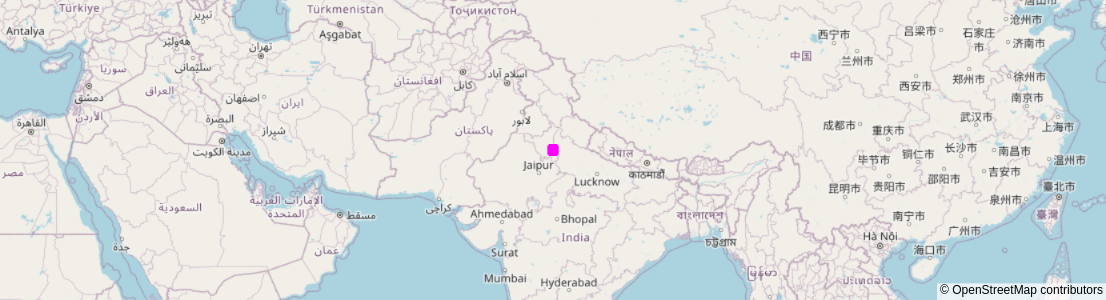

In [22]:
fig = px.scatter_mapbox(results, lat="lat", lon="lon", hover_name="PGA", hover_data=["PGA", "Vs30", 'Dis(km)'],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()